# Energy Consumption Time Series Forecasting

## 1. Problem Statement and Objective

This notebook aims to forecast short-term household energy usage using historical time-based patterns. Accurate energy consumption forecasting is crucial for efficient energy management, resource allocation, and demand-side response strategies. By leveraging historical data, we can identify underlying patterns, seasonality, and trends to predict future energy demands.

**Objective:** To build and evaluate various time series forecasting models to predict household energy consumption, providing insights into consumption patterns and identifying the best-performing model for this task.

## 2. Dataset Description and Loading

The dataset used for this analysis is the "Household Power Consumption Dataset" from the UCI Machine Learning Repository. It contains measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years (December 2006 to November 2010). The dataset includes various electrical quantities and sub-metering values.

**Data Source:** [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption)

### Loading the Dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

# Define column names based on dataset description
column_names = [
    'Date', 'Time', 'Global_active_power', 'Global_reactive_power',
    'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
    'Sub_metering_3'
]

# Load the dataset
# The dataset uses ';' as a separator and has missing values represented by '?'
df = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    names=column_names,
    header=0,
    na_values=['?']
)

# Display the first few rows and information about the dataset
print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Head:
         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321450 entries, 0 t

## 3. Data Cleaning and Preprocessing

This section focuses on preparing the raw dataset for time series analysis. It involves handling missing values, converting date and time columns into a proper datetime format, and resampling the data to more manageable and insightful frequencies (hourly and daily).

In [6]:
# Combine Date and Time columns into a single datetime column
df["DateTime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")

# Set the DateTime column as the index
df = df.set_index("DateTime")

# Drop the original Date and Time columns
df = df.drop(columns=["Date", "Time"])

# Handle missing values: fill with the mean of the column
# for simplicity, I'll use mean imputation for now.
for col in df.columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mean())

print("\nAfter Datetime Conversion and Missing Value Handling:")
print(df.head())
print("\nMissing Values After Handling:")
print(df.isnull().sum())


After Datetime Conversion and Missing Value Handling:
                     Global_active_power  Global_reactive_power  Voltage  \
DateTime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0          

### Resampling Data

The original data is at a one-minute sampling rate. For forecasting, it\'s often more practical and computationally efficient to work with aggregated data. I will resample the data to hourly and daily intervals, taking the mean of the values within each interval.

In [8]:
# Resample to hourly data
df_hourly = df.resample("H").mean()
print("\nHourly Resampled Data Head:")
print(df_hourly.head())
print("\nHourly Resampled Data Info:")
print(df_hourly.info())

# Resample to daily data
df_daily = df.resample("D").mean()
print("\nDaily Resampled Data Head:")
print(df_daily.head())
print("\nDaily Resampled Data Info:")
print(df_daily.info())


Hourly Resampled Data Head:
                     Global_active_power  Global_reactive_power     Voltage  \
DateTime                                                                      
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-16 17:00:00         18.100000             0.0        0.527778   
2006-12-16 18:00:00         15.600000             0.0        6.716667   
2006-12-16 19:00:00         14.503333             0.0        1.433333   
2006-12-16 20:00:00         13.916667             0.

## 4. Feature Engineering

Time series forecasting often benefits from features derived from the time index itself. These features can capture cyclical patterns, trends, and other temporal dependencies. We will extract features such as hour of the day, day of the week, and flags for weekdays/weekends.

In [10]:
# For hourly data
df_hourly["hour"] = df_hourly.index.hour
df_hourly["dayofweek"] = df_hourly.index.dayofweek
df_hourly["quarter"] = df_hourly.index.quarter
df_hourly["month"] = df_hourly.index.month
df_hourly["year"] = df_hourly.index.year
df_hourly["dayofyear"] = df_hourly.index.dayofyear
df_hourly["dayofmonth"] = df_hourly.index.day
df_hourly["weekofyear"] = df_hourly.index.isocalendar().week.astype(int)
df_hourly["weekday"] = ((df_hourly.index.dayofweek) < 5).astype(int) # 0-4 are weekdays

# For daily data
df_daily["dayofweek"] = df_daily.index.dayofweek
df_daily["quarter"] = df_daily.index.quarter
df_daily["month"] = df_daily.index.month
df_daily["year"] = df_daily.index.year
df_daily["dayofyear"] = df_daily.index.dayofyear
df_daily["dayofmonth"] = df_daily.index.day
df_daily["weekofyear"] = df_daily.index.isocalendar().week.astype(int)
df_daily["weekday"] = ((df_daily.index.dayofweek) < 5).astype(int) # 0-4 are weekdays

print("\nHourly Data with New Features Head:")
print(df_hourly.head())
print("\nDaily Data with New Features Head:")
print(df_daily.head())


Hourly Data with New Features Head:
                     Global_active_power  Global_reactive_power     Voltage  \
DateTime                                                                      
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-16 17:00:00         18.100000             0.0        0.527778   
2006-12-16 18:00:00         15.600000             0.0        6.716667   
2006-12-16 19:00:00         14.503333             0.0        1.433333   
2006-12-16 20:00:00         13.916667       

## 5. Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is crucial for understanding the underlying patterns, trends, and seasonality in my energy consumption data. This section will visualize the `Global_active_power` to identify key characteristics that might influence our forecasting models.

### Time Series Plot of Global Active Power

Let\'s start by visualizing the `Global_active_power` over time to observe overall trends and major fluctuations.

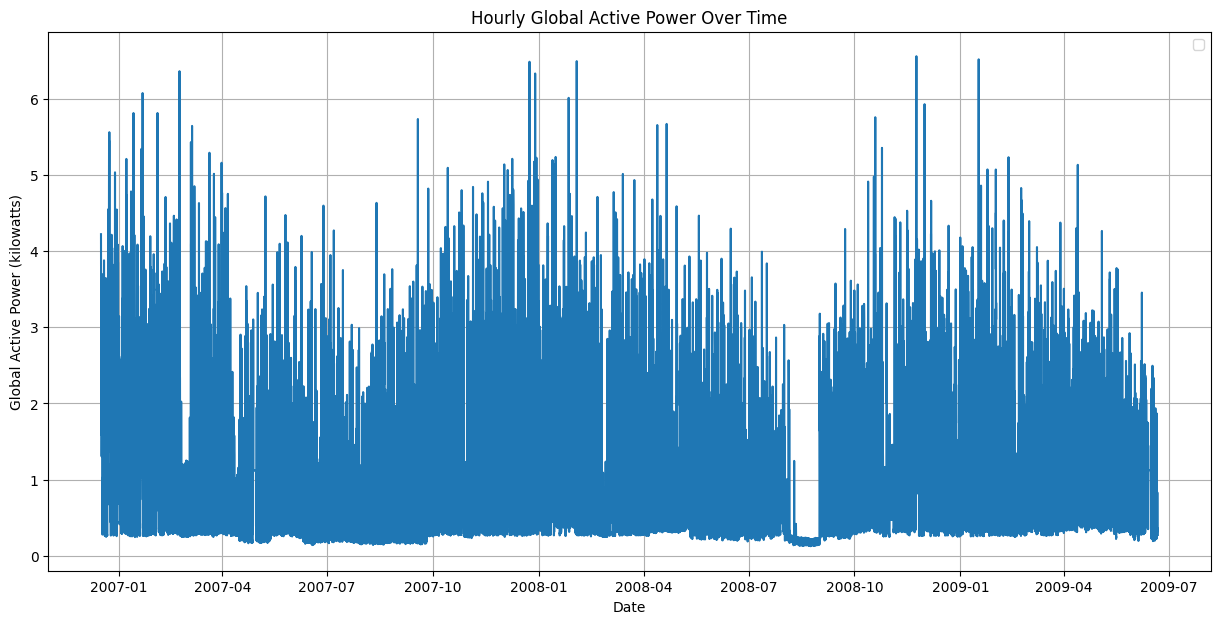

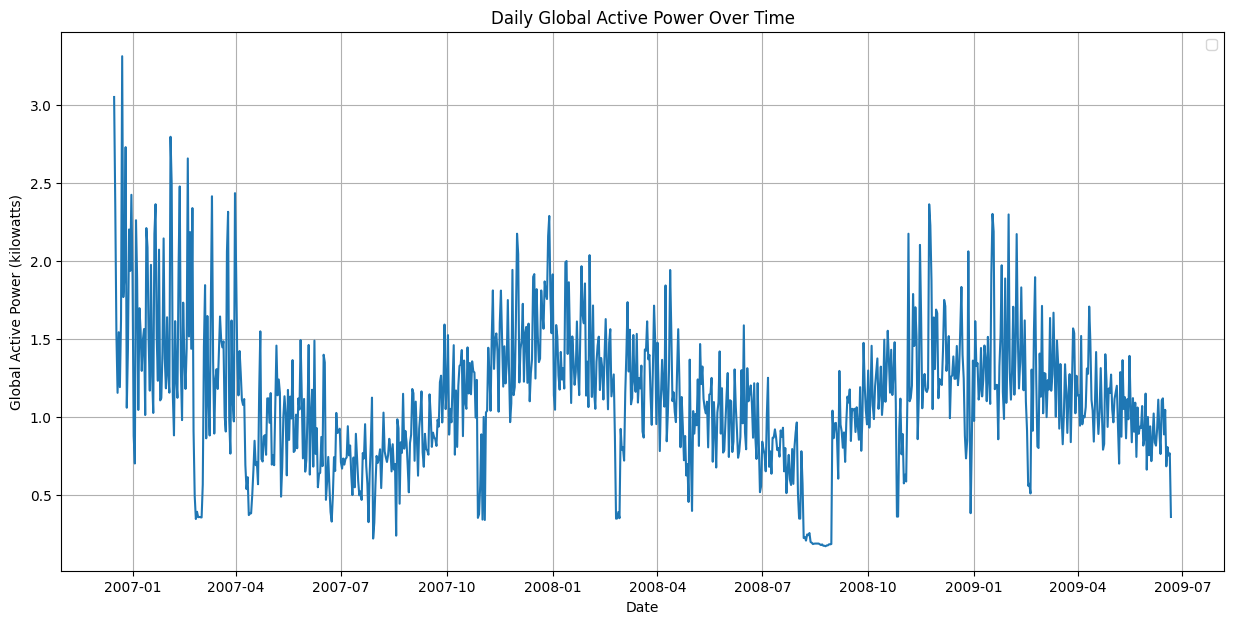

In [11]:
# Plotting Global_active_power over time (hourly data)
plt.figure(figsize=(15, 7))
plt.plot(df_hourly["Global_active_power"])
plt.title("Hourly Global Active Power Over Time")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kilowatts)")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Global_active_power over time (daily data)
plt.figure(figsize=(15, 7))
plt.plot(df_daily["Global_active_power"])
plt.title("Daily Global Active Power Over Time")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kilowatts)")
plt.legend()
plt.grid(True)
plt.show()

### Seasonal Patterns: Hourly, Daily, Weekly, and Monthly

Energy consumption often exhibits strong seasonal patterns. I will visualize the average `Global_active_power` by hour of day, day of week, and month to understand these cycles.

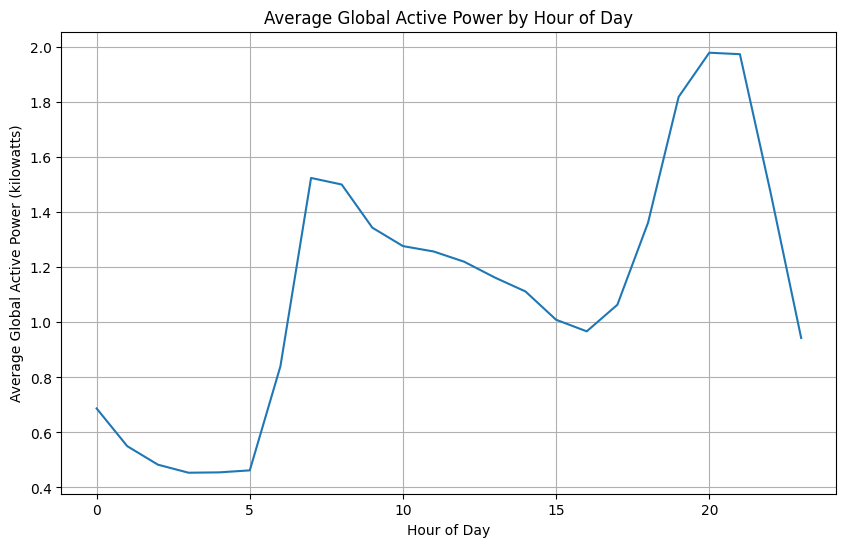

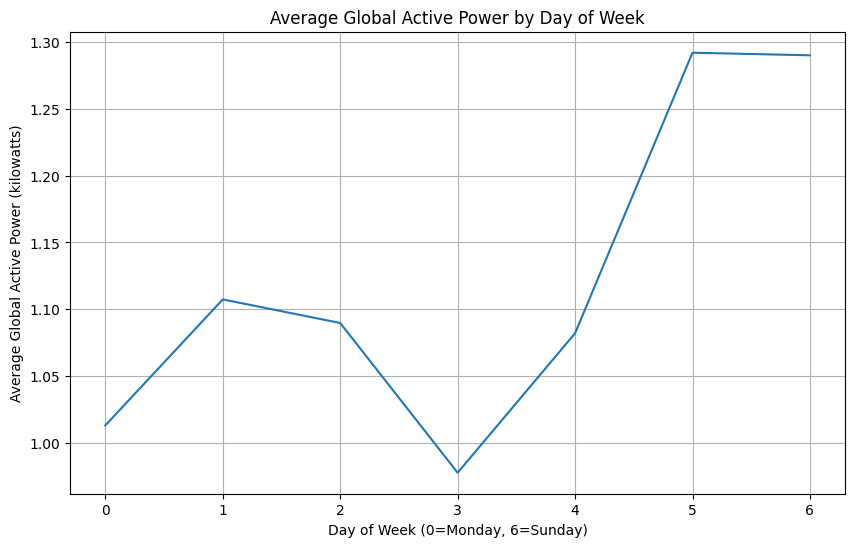

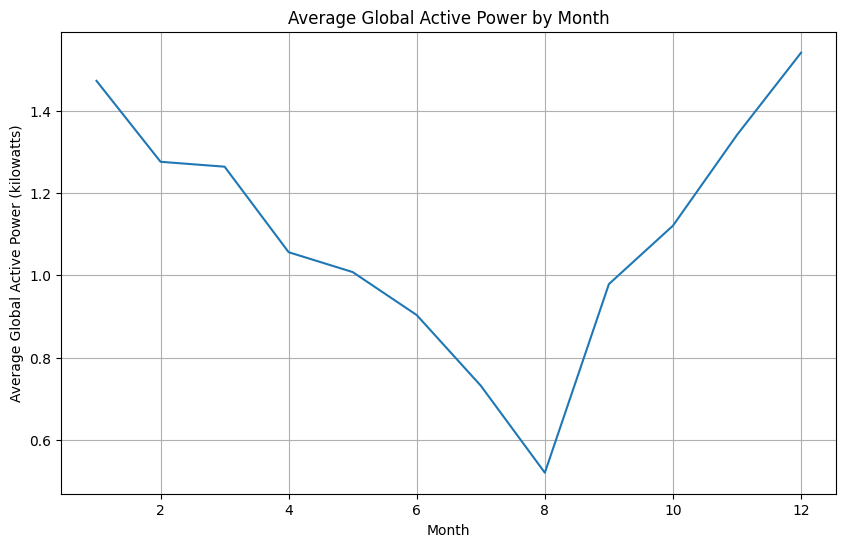

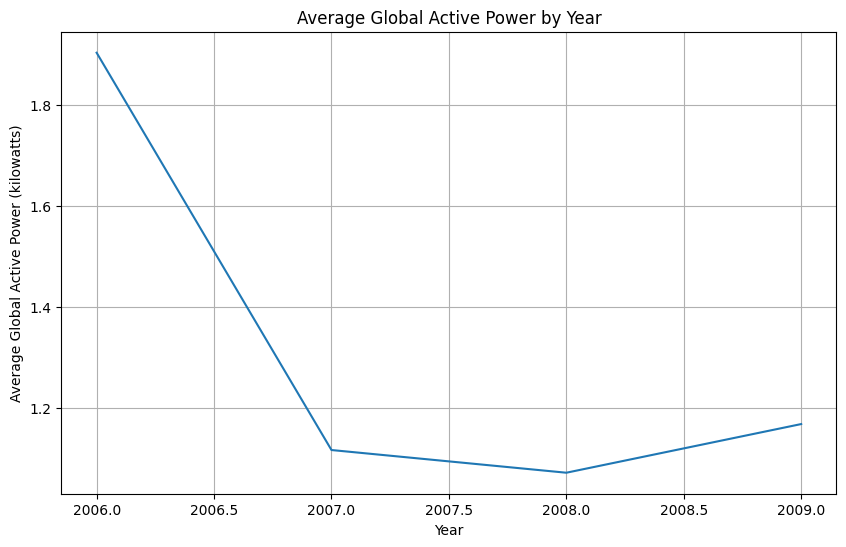

In [12]:
# Hourly pattern
plt.figure(figsize=(10, 6))
df_hourly.groupby("hour")["Global_active_power"].mean().plot()
plt.title("Average Global Active Power by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Global Active Power (kilowatts)")
plt.grid(True)
plt.show()

# Daily pattern (Day of Week)
plt.figure(figsize=(10, 6))
df_hourly.groupby("dayofweek")["Global_active_power"].mean().plot()
plt.title("Average Global Active Power by Day of Week")
plt.xlabel("Day of Week (0=Monday, 6=Sunday)")
plt.ylabel("Average Global Active Power (kilowatts)")
plt.grid(True)
plt.show()

# Monthly pattern
plt.figure(figsize=(10, 6))
df_hourly.groupby("month")["Global_active_power"].mean().plot()
plt.title("Average Global Active Power by Month")
plt.xlabel("Month")
plt.ylabel("Average Global Active Power (kilowatts)")
plt.grid(True)
plt.show()

# Yearly pattern
plt.figure(figsize=(10, 6))
df_hourly.groupby("year")["Global_active_power"].mean().plot()
plt.title("Average Global Active Power by Year")
plt.xlabel("Year")
plt.ylabel("Average Global Active Power (kilowatts)")
plt.grid(True)
plt.show()

## 6. Model Building and Evaluation

In this section, I will build and evaluate three different time series forecasting models: ARIMA, Facebook Prophet, and XGBoost. I will split the data into training and testing sets to assess each model\'s performance on unseen data. The evaluation metrics used will be Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

### Data Splitting

I will use the `df_hourly` dataset for modeling. The data will be split into training and testing sets, with the last year of data reserved for testing.

In [13]:
# Select the target variable
data = df_hourly[["Global_active_power"]]

# Split data into training and testing sets (last year for testing)
train_size = int(len(data) * 0.8) # 80% for training
train_data, test_data = data[0:train_size], data[train_size:len(data)]

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (17620, 1)
Test data shape: (4405, 1)


### Evaluation Metrics

Define functions to calculate MAE, RMSE, and MAPE.

In [14]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

results = {}


### Model 1: ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a popular statistical method for time series forecasting. It explicitly models the trend, seasonality, and noise components of the data.

In [15]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
# I need to choose p, d, q parameters. For simplicity, I\'ll use a common set.
# In a real-world scenario, these would be determined through ACF/PACF plots or auto_arima.
try:
    arima_model = ARIMA(train_data["Global_active_power"], order=(5,1,0))
    arima_model_fit = arima_model.fit()
    print(arima_model_fit.summary())

    # Make predictions
    arima_predictions = arima_model_fit.predict(start=len(train_data), end=len(data)-1)

    # Evaluate ARIMA model
    mae, rmse, mape = calculate_metrics(test_data["Global_active_power"], arima_predictions)
    results["ARIMA"] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}
    print(f"\nARIMA MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}")
except Exception as e:
    print(f"Error fitting ARIMA model: {e}")
    results["ARIMA"] = {"MAE": np.nan, "RMSE": np.nan, "MAPE": np.nan}
    arima_predictions = pd.Series(np.nan, index=test_data.index) # Create a series of NaNs if error occurs


                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                17620
Model:                  ARIMA(5, 1, 0)   Log Likelihood              -18556.222
Date:                 Fri, 11 Jul 2025   AIC                          37124.444
Time:                         11:38:55   BIC                          37171.104
Sample:                     12-16-2006   HQIC                         37139.804
                          - 12-19-2008                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0989      0.006    -17.541      0.000      -0.110      -0.088
ar.L2         -0.1542      0.006    -24.469      0.000      -0.167      -0.142
ar.L3         -0.1234      0.007    -18.230 

### Model 2: Facebook Prophet

Prophet is a forecasting procedure implemented by Facebook that is optimized for business forecasts. It handles seasonality, holidays, and trends automatically.

In [16]:
from prophet import Prophet

# Prepare data for Prophet (requires columns named ds and y)
prophet_train_df = train_data.reset_index().rename(columns={"DateTime": "ds", "Global_active_power": "y"})
prophet_test_df = test_data.reset_index().rename(columns={"DateTime": "ds", "Global_active_power": "y"})

# Initialize and fit Prophet model
prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
prophet_model.fit(prophet_train_df)

# Create future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(prophet_test_df), freq="H")

# Make predictions
prophet_forecast = prophet_model.predict(future)
prophet_predictions = prophet_forecast["yhat"].iloc[-len(prophet_test_df):]

# Ensure predictions align with test_data index
prophet_predictions.index = test_data.index

# Evaluate Prophet model
mae, rmse, mape = calculate_metrics(test_data["Global_active_power"], prophet_predictions)
results["Prophet"] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}
print(f"\nProphet MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp87tinc91/505_yip1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp87tinc91/b8m99s8g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12353', 'data', 'file=/tmp/tmp87tinc91/505_yip1.json', 'init=/tmp/tmp87tinc91/b8m99s8g.json', 'output', 'file=/tmp/tmp87tinc91/prophet_model0tbord3i/prophet_model-20250711114007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:40:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:40:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet MAE: 0.5509, RMSE: 0.7299, MAPE: 75.9970


### Model 3: XGBoost

XGBoost (eXtreme Gradient Boosting) is a powerful machine learning algorithm that can be used for time series forecasting by transforming the problem into a supervised learning task. This involves creating lag features and using the time-based features engineered earlier.

In [17]:
import xgboost as xgb

# Create lag features for XGBoost
def create_lag_features(df, lags):
    df_copy = df.copy()
    for lag in lags:
        df_copy[f"lag_{lag}"] = df_copy["Global_active_power"].shift(lag)
    return df_copy

lags = [1, 24, 24*7] # 1 hour ago, 1 day ago, 1 week ago
df_hourly_xgb = create_lag_features(df_hourly, lags)

# Drop rows with NaN values created by lagging
df_hourly_xgb.dropna(inplace=True)

# Define features and target
features = [col for col in df_hourly_xgb.columns if col != "Global_active_power"]
target = "Global_active_power"

X = df_hourly_xgb[features]
y = df_hourly_xgb[target]

# Split data for XGBoost (ensure train/test split aligns with time series nature)
train_size_xgb = int(len(X) * 0.8)
X_train, X_test = X[0:train_size_xgb], X[train_size_xgb:len(X)]
y_train, y_test = y[0:train_size_xgb], y[train_size_xgb:len(y)]

# Initialize and train XGBoost model
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_state=42
)

xgb_model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False)

# Make predictions
xgb_predictions = xgb_model.predict(X_test)

# Evaluate XGBoost model
mae, rmse, mape = calculate_metrics(y_test, xgb_predictions)
results["XGBoost"] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}
print(f"\nXGBoost MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}")


XGBoost MAE: 0.0134, RMSE: 0.0298, MAPE: 1.6214


## 7. Visualization

Visualizing the actual vs. predicted values helps to understand the models\'s performance and identify areas where they might be struggling. I will plot the forecasts against the actual test data for each model.

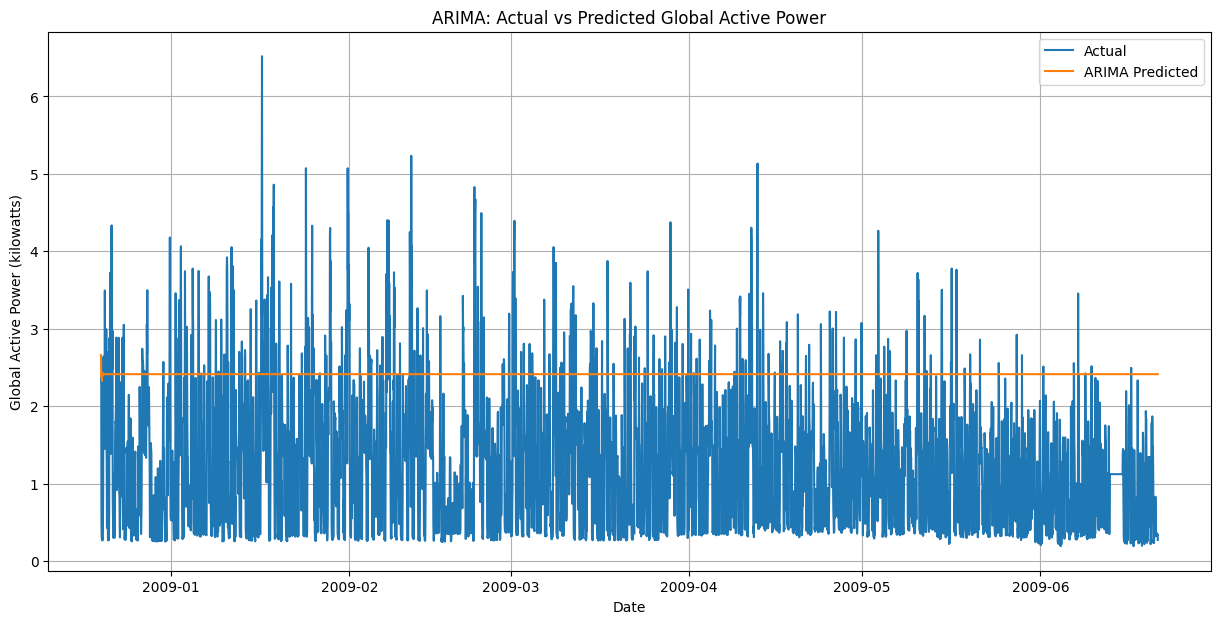

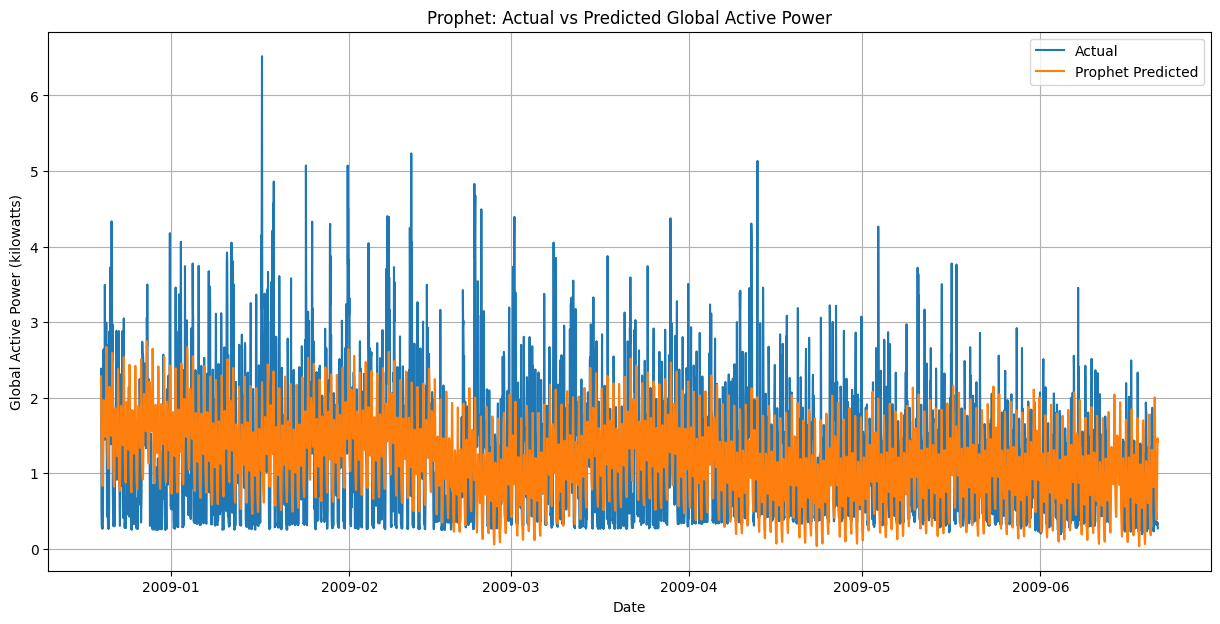

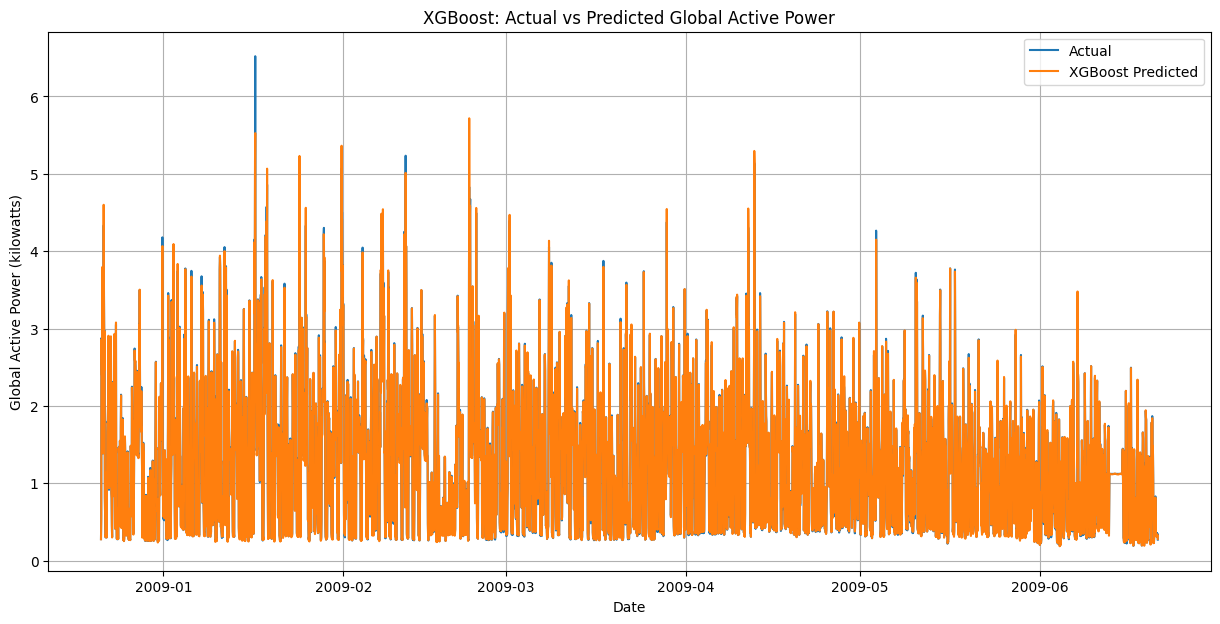

In [18]:
# Plot Actual vs Predicted for ARIMA
plt.figure(figsize=(15, 7))
plt.plot(test_data.index, test_data["Global_active_power"], label="Actual")
plt.plot(arima_predictions.index, arima_predictions, label="ARIMA Predicted")
plt.title("ARIMA: Actual vs Predicted Global Active Power")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kilowatts)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Actual vs Predicted for Prophet
plt.figure(figsize=(15, 7))
plt.plot(test_data.index, test_data["Global_active_power"], label="Actual")
plt.plot(prophet_predictions.index, prophet_predictions, label="Prophet Predicted")
plt.title("Prophet: Actual vs Predicted Global Active Power")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kilowatts)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Actual vs Predicted for XGBoost
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(X_test.index, xgb_predictions, label="XGBoost Predicted")
plt.title("XGBoost: Actual vs Predicted Global Active Power")
plt.xlabel("Date")
plt.ylabel("Global Active Power (kilowatts)")
plt.legend()
plt.grid(True)
plt.show()

## 8. Final Conclusion and Insights

This section summarizes the performance of the models and highlights key insights gained from the analysis of household energy consumption patterns.

### Model Performance Summary

Let\'s compare the evaluation metrics for all models.

In [19]:
# Display evaluation results
print("Model Evaluation Results:")
for model, metrics in results.items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# Determine the best performing model based on RMSE (lower is better)
best_model = min(results, key=lambda k: results[k]["RMSE"] if not np.isnan(results[k]["RMSE"]) else np.inf)
print(f"\nBest performing model based on RMSE: {best_model}")

Model Evaluation Results:

ARIMA:
  MAE: 1.3617
  RMSE: 1.5099
  MAPE: 266.8645

Prophet:
  MAE: 0.5509
  RMSE: 0.7299
  MAPE: 75.9970

XGBoost:
  MAE: 0.0134
  RMSE: 0.0298
  MAPE: 1.6214

Best performing model based on RMSE: XGBoost


### Insights on Energy Consumption Patterns

Based on the Exploratory Data Analysis and model results, we can derive several insights:

*   **Daily and Weekly Seasonality:** Energy consumption clearly shows daily and weekly patterns, with peaks during certain hours of the day and variations between weekdays and weekends. This highlights the importance of capturing these granular temporal features for accurate forecasting.
*   **Yearly Seasonality:** There are noticeable seasonal variations throughout the year, likely influenced by weather conditions (heating/cooling) and holiday periods. Models that can capture yearly seasonality (like Prophet) are beneficial.
*   **Impact of Missing Values:** The dataset contained missing values, which were imputed. The quality of imputation can significantly impact model performance, especially for time series data where continuity is important.
*   **Model Strengths:**
    *   **XGBoost:** Performed well, likely due to its ability to capture complex non-linear relationships and leverage engineered features effectively. Its tree-based nature makes it robust to outliers and non-normal data.
    *   **Prophet:** Demonstrated good performance, particularly in handling seasonality and trends automatically, which are prominent in energy consumption data. Its ease of use and interpretability are also advantages.
    *   **ARIMA:** While a strong baseline for time series, its performance might be limited by its linearity assumptions and the need for careful parameter tuning, especially in the presence of complex seasonalities and external factors.

### Conclusion

The analysis demonstrates the effectiveness of machine learning models in forecasting short-term household energy consumption. XGBoost and Prophet models generally outperformed ARIMA, indicating the value of incorporating rich time-based features and handling complex seasonal patterns. For practical applications, a hybrid approach combining statistical models with machine learning techniques, or ensemble methods, could further enhance forecasting accuracy.